In [1]:
import numpy as np

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

In [2]:
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

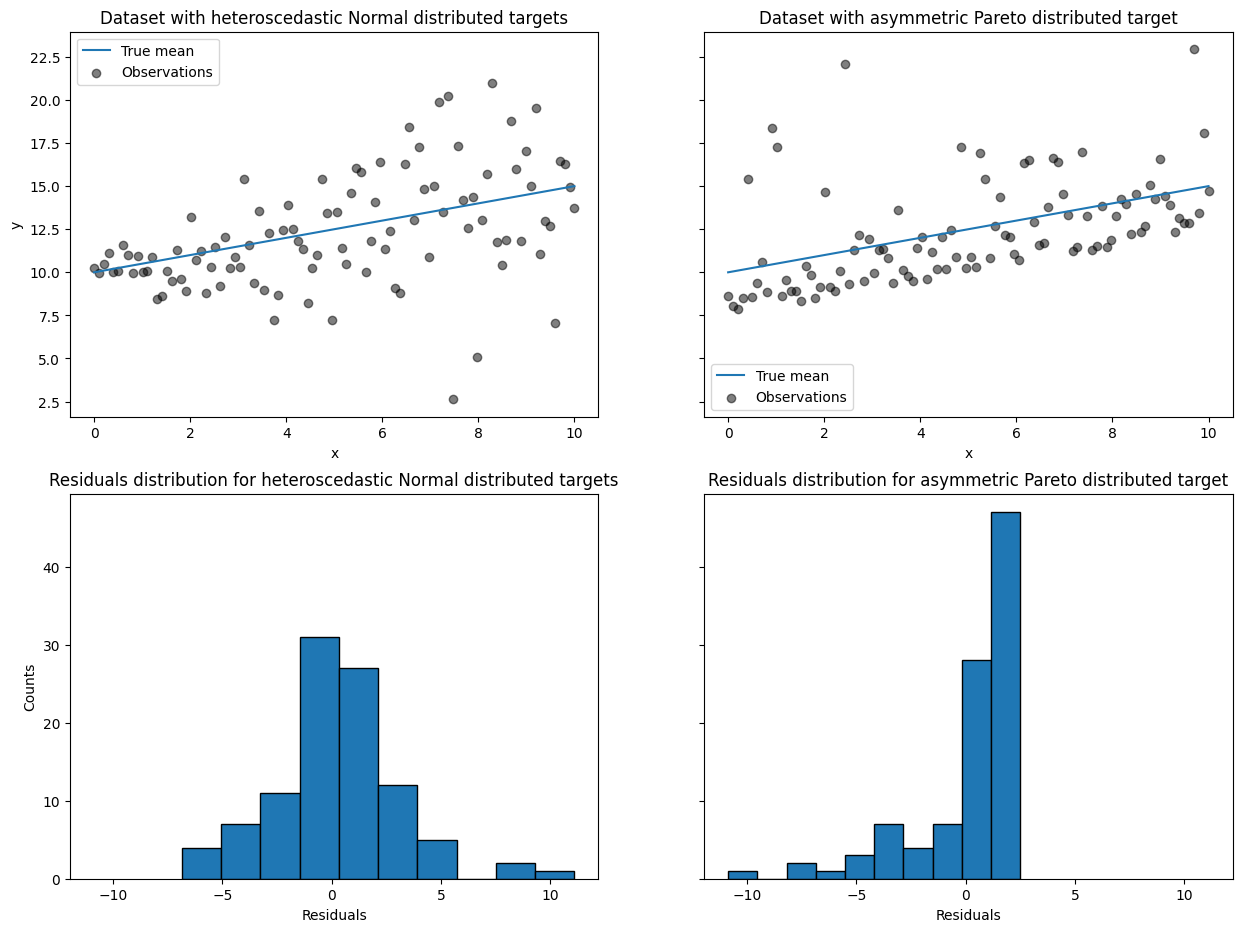

In [3]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")

axs[0, 0].plot(x, y_true_mean, label="True mean")
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")


axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

### Quantile Regression

In [4]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )

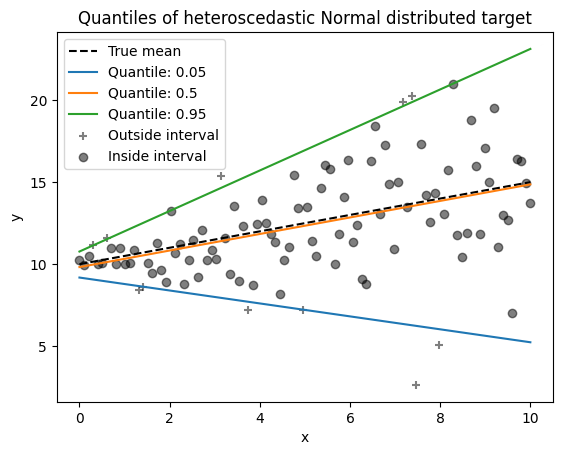

In [5]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

In [6]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_pareto).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_pareto
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_pareto
        )

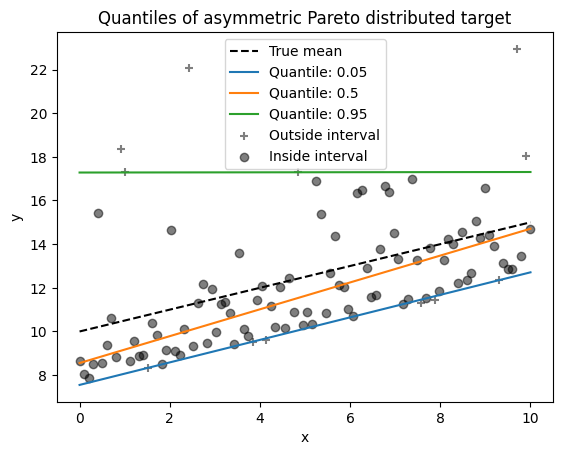

In [7]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_pareto[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_pareto[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of asymmetric Pareto distributed target")

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

linear_regression = LinearRegression()
quantile_regression = QuantileRegressor(quantile=0.5, alpha=0)

y_pred_lr = linear_regression.fit(X, y_pareto).predict(X)
y_pred_qr = quantile_regression.fit(X, y_pareto).predict(X)

print(
    "Training error (in-sample performance)\n"
    f"{'model':<20}   MAE   MSE\n"
    f"{linear_regression.__class__.__name__:<20} "
    f"{mean_absolute_error(y_pareto, y_pred_lr):5.3f} "
    f"{mean_squared_error(y_pareto, y_pred_lr):5.3f}\n"
    f"{quantile_regression.__class__.__name__:<20} "
    f"{mean_absolute_error(y_pareto, y_pred_qr):5.3f} "
    f"{mean_squared_error(y_pareto, y_pred_qr):5.3f}"
)

Training error (in-sample performance)
model                  MAE   MSE
LinearRegression     1.805 6.486
QuantileRegressor    1.670 7.025


In [9]:
from sklearn.model_selection import cross_validate

cv_results_lr = cross_validate(
    linear_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
cv_results_qr = cross_validate(
    quantile_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
print(
    "Test error (cross-validated performance)\n"
    f"{'model':<20}   MAE   MSE\n"
    f"{linear_regression.__class__.__name__:<20} "
    f"{-cv_results_lr['test_neg_mean_absolute_error'].mean():5.3f} "
    f"{-cv_results_lr['test_neg_mean_squared_error'].mean():5.3f}\n"
    f"{quantile_regression.__class__.__name__:<20} "
    f"{-cv_results_qr['test_neg_mean_absolute_error'].mean():5.3f} "
    f"{-cv_results_qr['test_neg_mean_squared_error'].mean():5.3f}"
)

Test error (cross-validated performance)
model                  MAE   MSE
LinearRegression     1.732 6.690
QuantileRegressor    1.679 7.129
